In [91]:
from typing import Optional, Tuple, List, Dict, Any, Union
import os
from pathlib import Path
import numpy as np
from glob import glob
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import rasterio
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, Dice, BinaryPrecision, BinaryRecall
from torchvision import transforms
import segmentation_models_pytorch as smp

## Evaluate different backbones

In [2]:
efficientnet_b0 = "efficientnet-b0"
resnet18 = "resnet18"
timm_resnest14d = "timm-resnest14d"
vgg11 = "vgg11"

filename = f"u_net_undersampling_cleaned_verified_{efficientnet_b0}_10_16_0.005_None"
efficientnet_b0_df = pd.read_csv(f"trainings_results/{filename}.csv")
filename = f"u_net_undersampling_cleaned_verified_{resnet18}_10_16_0.005_None"
resnet18_df = pd.read_csv(f"trainings_results/{filename}.csv")
filename = f"u_net_undersampling_cleaned_verified_{timm_resnest14d}_10_16_0.005_None"
timm_resnest14d_df = pd.read_csv(f"trainings_results/{filename}.csv")
filename = f"u_net_undersampling_cleaned_verified_{vgg11}_10_16_0.005_None"
vgg11_df = pd.read_csv(f"trainings_results/{filename}.csv")

In [3]:
efficientnet_b0_df

,train_loss_epochs,val_loss_epochs,val_dice_epochs,validation_f1_epochs,validation_precision_epochs,validation_recall_epochs
0,0.100896,0.025047,0.180264,0.172067,0.588151,0.114843
1,0.013807,0.013240,0.520241,0.516143,0.796662,0.416374
2,0.008165,0.013147,0.627722,0.619525,0.681374,0.622264
3,0.005791,0.085404,0.641159,0.637061,0.703263,0.637788
4,0.004506,0.021380,0.641897,0.629601,0.722568,0.606460
5,0.003592,0.094286,0.622323,0.610028,0.737931,0.605108
6,0.002940,0.057201,0.651443,0.647344,0.646964,0.718957
7,0.002541,0.133308,0.643928,0.639830,0.744178,0.635748
8,0.002203,0.021527,0.697187,0.680794,0.765261,0.663873
9,0.002162,0.114322,0.698613,0.686318,0.706779,0.726360


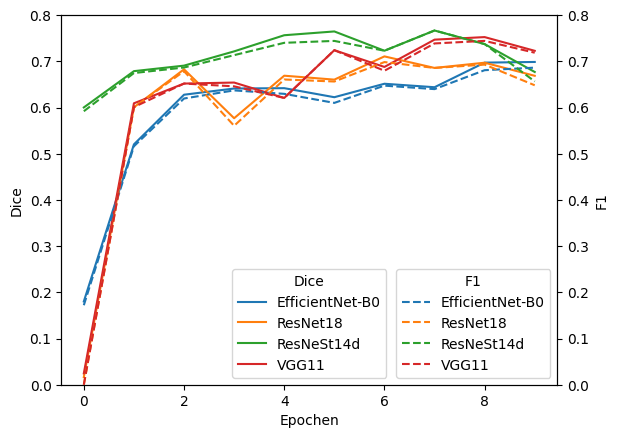

In [71]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(efficientnet_b0_df.val_dice_epochs, label="EfficientNet-B0")
ax1.plot(resnet18_df.val_dice_epochs, label="ResNet18")
ax1.plot(timm_resnest14d_df.val_dice_epochs, label="ResNeSt14d")
ax1.plot(vgg11_df.val_dice_epochs, label="VGG11")
ax1.set_xlabel("Epochen")
ax1.set_ylabel("Dice")
ax2.plot(efficientnet_b0_df.validation_f1_epochs, label="EfficientNet-B0", color="C0", linestyle="--")
ax2.plot(resnet18_df.validation_f1_epochs, label="ResNet18", color="C1", linestyle="--")
ax2.plot(timm_resnest14d_df.validation_f1_epochs, label="ResNeSt14d", color="C2", linestyle="--")
ax2.plot(vgg11_df.validation_f1_epochs, label="VGG11", color="C3", linestyle="--")
ax2.set_ylabel("F1")
ax1.legend(title="Dice", loc="lower center")
ax2.legend(title="F1", loc="lower right")
ax1.set_ylim(0.0, 0.8)
ax2.set_ylim(0.0, 0.8)
plt.show()

In [72]:
# save figure
fig.savefig('figures/cleaned_verified_data/Backbones_Performance.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/Backbones_Performance.svg', bbox_inches='tight')

In [280]:
overview_df = pd.DataFrame(columns=["Model", "Max. Dice (%)", "Max. F1 (%)","Mean Dice (%)" ,"Mean F1 (%)", "Mean Precision (%)", "Mean Recall (%)"])
overview_df.loc[0] = ["EfficientNet-B0", round(efficientnet_b0_df.val_dice_epochs.max()*100, 2), round(efficientnet_b0_df.validation_f1_epochs.max()*100, 2), round(efficientnet_b0_df.val_dice_epochs.mean()*100, 2), round(efficientnet_b0_df.validation_f1_epochs.mean()*100, 2), round(efficientnet_b0_df.validation_precision_epochs.mean()*100, 2), round(efficientnet_b0_df.validation_recall_epochs.mean()*100, 2)]
overview_df.loc[1] = ["ResNet18", round(resnet18_df.val_dice_epochs.max()*100, 2), round(resnet18_df.validation_f1_epochs.max()*100, 2), round(resnet18_df.val_dice_epochs.mean()*100, 2), round(resnet18_df.validation_f1_epochs.mean()*100, 2), round(resnet18_df.validation_precision_epochs.mean()*100, 2), round(resnet18_df.validation_recall_epochs.mean()*100, 2)]
overview_df.loc[2] = ["ResNeSt14d", round(timm_resnest14d_df.val_dice_epochs.max()*100, 2), round(timm_resnest14d_df.validation_f1_epochs.max()*100, 2), round(timm_resnest14d_df.val_dice_epochs.mean()*100, 2), round(timm_resnest14d_df.validation_f1_epochs.mean()*100, 2), round(timm_resnest14d_df.validation_precision_epochs.mean()*100, 2), round(timm_resnest14d_df.validation_recall_epochs.mean()*100, 2)]
overview_df.loc[3] = ["VGG11", round(vgg11_df.val_dice_epochs.max()*100, 2), round(vgg11_df.validation_f1_epochs.max()*100, 2), round(vgg11_df.val_dice_epochs.mean()*100, 2), round(vgg11_df.validation_f1_epochs.mean()*100, 2), round(vgg11_df.validation_precision_epochs.mean()*100, 2), round(vgg11_df.validation_recall_epochs.mean()*100, 2)]
overview_df

,Model,Max. Dice (%),Max. F1 (%),Mean Dice (%),Mean F1 (%),Mean Precision (%),Mean Recall (%)
0,EfficientNet-B0,69.86,68.63,59.25,58.39,70.93,57.48
1,ResNet18,71.07,69.84,59.68,58.82,69.20,55.07
2,ResNeSt14d,76.67,76.67,71.16,70.34,76.15,69.63
3,VGG11,75.25,74.43,61.94,61.25,68.67,59.46


In [282]:
overview_df.to_csv("trainings_results/Backbones_Performance.csv", index=False)

### Cleaned vs cleaned + verified data

In [275]:

filename = f"u_net_undersampling_cleaned_{timm_resnest14d}_15_16_0.005_None"
timm_resnest14d_cleaned_df = pd.read_csv(f"trainings_results/{filename}.csv")
filename = f"u_net_undersampling_cleaned_verified_{timm_resnest14d}_15_16_0.005_None"
timm_resnest14d__verified_df = pd.read_csv(f"trainings_results/{filename}.csv")

In [283]:
cleaned_vs_verifed_df = pd.DataFrame(columns=["Dataset", "Max. Dice (%)", "Max. F1 (%)", "Mean Dice (%)" ,"Mean F1 (%)", "Mean Precision (%)", "Mean Recall (%)"])
cleaned_vs_verifed_df.loc[0] = ["Cleaned", timm_resnest14d_cleaned_df.val_dice_epochs.max()*100, timm_resnest14d_cleaned_df.validation_f1_epochs.max()*100, timm_resnest14d_cleaned_df.val_dice_epochs.mean()*100, timm_resnest14d_cleaned_df.validation_f1_epochs.mean()*100, timm_resnest14d_cleaned_df.validation_precision_epochs.mean()*100, timm_resnest14d_cleaned_df.validation_recall_epochs.mean()*100]
cleaned_vs_verifed_df.loc[1] = ["Cleaned + Verified", timm_resnest14d__verified_df.val_dice_epochs.max()*100, timm_resnest14d__verified_df.validation_f1_epochs.max()*100, timm_resnest14d__verified_df.val_dice_epochs.mean()*100, timm_resnest14d__verified_df.validation_f1_epochs.mean()*100, timm_resnest14d__verified_df.validation_precision_epochs.mean()*100, timm_resnest14d__verified_df.validation_recall_epochs.mean()*100]

cleaned_vs_verifed_df = cleaned_vs_verifed_df.round({"Max. Dice (%)": 2, "Max. F1 (%)": 2, "Mean Dice (%)": 2, "Mean F1 (%)": 2, "Mean Precision (%)": 2, "Mean Recall (%)": 2})

cleaned_vs_verifed_df

,Dataset,Max. Dice (%),Max. F1 (%),Mean Dice (%),Mean F1 (%),Mean Precision (%),Mean Recall (%)
0,Cleaned,77.76,77.36,40.43,39.55,49.82,38.65
1,Cleaned + Verified,75.20,74.79,69.02,67.68,79.13,64.23


In [281]:
cleaned_vs_verifed_df.to_csv("trainings_results/cleaned_vs_verifed_df.csv", index=False)

## Evaluate Training

In [18]:
filename = f"u_net_undersampling_cleaned_verified_{timm_resnest14d}_15_16_0.005_None"

In [19]:
df = pd.read_csv(f"trainings_results/{filename}.csv")
pickle_in = open(f"trainings_results/{filename}.pkl","rb")

In [20]:
pickle_dict = pickle.load(pickle_in)

In [21]:
pickle_dict.keys()

dict_keys(['train_loss_epochs', 'val_loss_epochs', 'val_dice_epochs', 'validation_f1_epochs', 'validation_precision_epochs', 'validation_recall_epochs', 'train_loss_steps', 'validation_loss_steps', 'validation_dice_steps'])

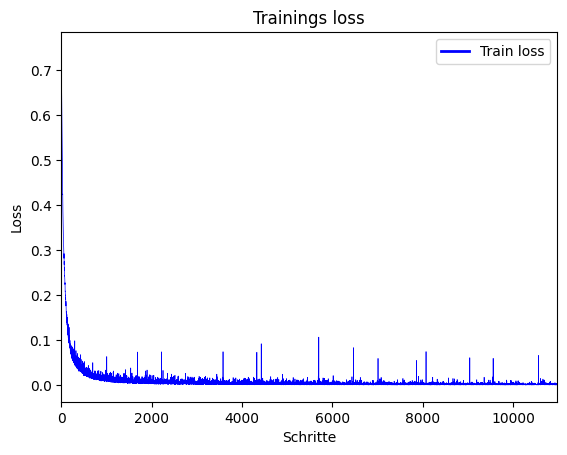

In [73]:
train_loss_steps = pickle_dict["train_loss_steps"]
epochs = range(1, len(train_loss_steps) + 1)

# Add trend curve
z_jaccard = np.polyfit(epochs, train_loss_steps, 2)
p_jaccard = np.poly1d(z_jaccard)
plt.plot(train_loss_steps, 'b', label='Train loss', linewidth=0.5)
# plt.plot(epochs, p_jaccard(epochs), "r--", label='Trend', linewidth=0.1)

plt.title('Trainings loss')
plt.xlabel('Schritte')
plt.ylabel('Loss')
plt.xlim(0, len(train_loss_steps))
# plt.ylim(0, 1)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()


In [74]:
fig.savefig('figures/cleaned_verified_data/train_loss.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/train_loss.svg', bbox_inches='tight')

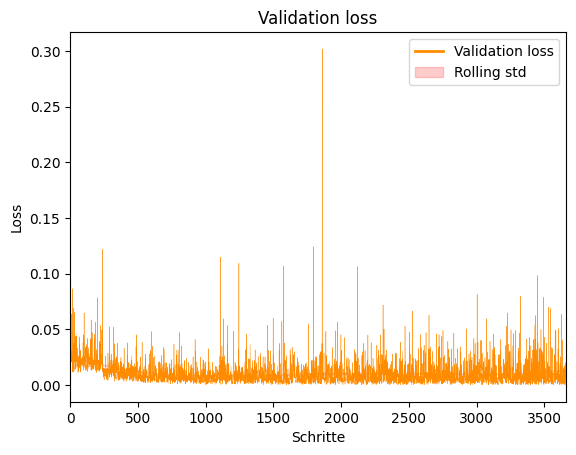

In [75]:
val_loss_steps = pickle_dict["validation_loss_steps"]
epochs = range(1, len(val_loss_steps) + 1)
orange = '#FF8C00'
# Add trend curve
z_jaccard = np.polyfit(epochs, val_loss_steps, 4)
p_jaccard = np.poly1d(z_jaccard)

plt.plot(val_loss_steps, color=orange, label='Validation loss', linewidth=0.3)
# plt.plot(epochs, p_jaccard(epochs), "r--", label='Trend',  linewidth=2)

window_size = 200
rolling_std = pd.Series(val_loss_steps).rolling(window_size, min_periods=1).var().values

plt.fill_between(epochs, p_jaccard(epochs)-rolling_std, p_jaccard(epochs)+rolling_std, alpha=0.2, color='red', label='Rolling std')

plt.title('Validation loss')
plt.xlabel('Schritte')
plt.ylabel('Loss')

plt.xlim(0, len(val_loss_steps))
# plt.ylim(0, 1)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

In [76]:
fig.savefig('figures/cleaned_verified_data/validation_loss.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/validation_loss.svg', bbox_inches='tight')

#### Dice Coefficient

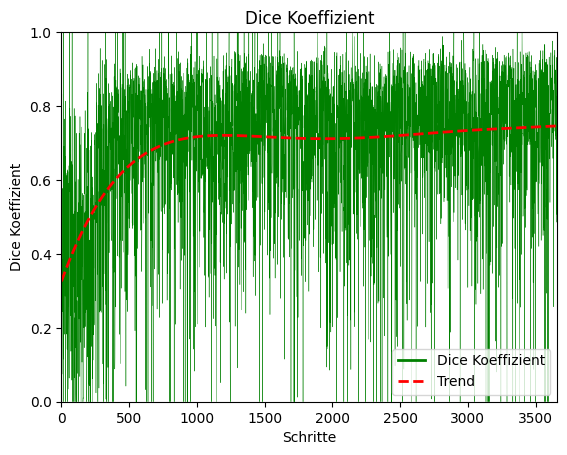

In [78]:
validation_dice_steps = pickle_dict["validation_dice_steps"]
epochs = range(1, len(validation_dice_steps) + 1)

# Add trend curve
z_dice = np.polyfit(epochs, validation_dice_steps, 5)
p_dice = np.poly1d(z_dice)
plt.plot(validation_dice_steps, 'g', label='Dice Koeffizient', linewidth=0.3)
plt.plot(epochs, p_dice(epochs), "r--", label='Trend', linewidth=2)

plt.title('Dice Koeffizient')
plt.xlabel('Schritte')
plt.ylabel('Dice Koeffizient')
plt.xlim(0, len(validation_dice_steps))
plt.ylim(0, 1)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

In [79]:
fig.savefig('figures/cleaned_verified_data/dice.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/dice.svg', bbox_inches='tight')

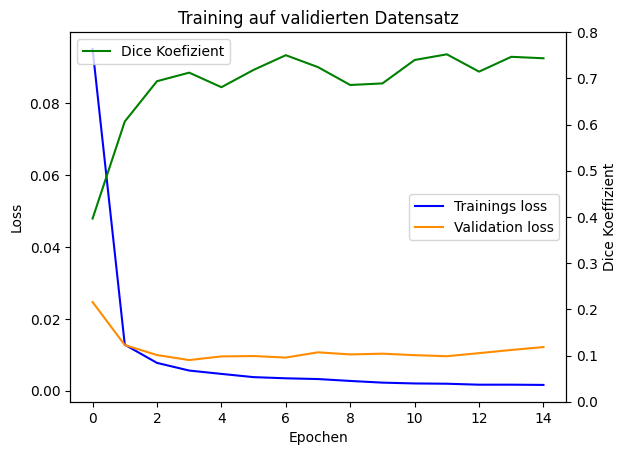

In [81]:
train_loss_epochs = pickle_dict["train_loss_epochs"]
val_loss_epochs = pickle_dict["val_loss_epochs"]
val_dice_epochs = pickle_dict["val_dice_epochs"]

epochs = range(1, len(train_loss_epochs) + 1)
orange = '#FF8C00'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(train_loss_epochs, 'b-', label='Trainings loss')
ax1.plot(val_loss_epochs, '-', color=orange, label='Validation loss')
ax2.plot(val_dice_epochs, 'g-', label='Dice Koefizient')
plt.title('Training auf validierten Datensatz')

ax1.set_xlabel('Epochen')
ax1.set_ylabel('Loss')
ax1.legend(loc='center right')
ax2.legend(loc='upper left')


ax2.set_ylabel('Dice Koeffizient')
# plt.xlim(0, len(train_loss_epochs))
# ax1.set_ylim(0, 0.1)
ax2.set_ylim(0, 0.8)
# plt.legend()
plt.show()

In [82]:
fig.savefig('figures/cleaned_verified_data/trainings_epochs.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/trainings_epochs.svg', bbox_inches='tight')

### Metrics

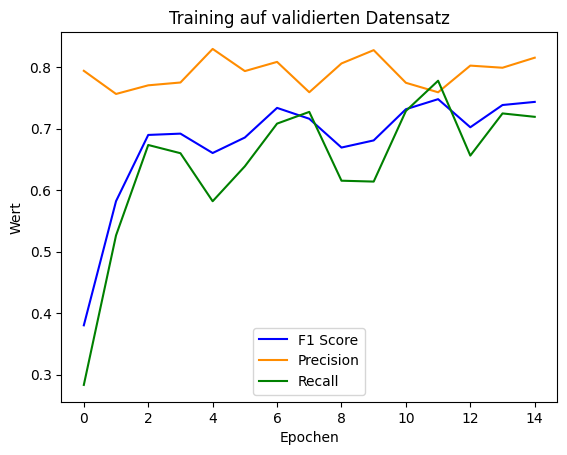

In [84]:
f1_score = pickle_dict['validation_f1_epochs']
precision = pickle_dict['validation_precision_epochs']
recall = pickle_dict['validation_recall_epochs']
epochs = range(1, len(f1_score) + 1)
orange = '#FF8C00'
fig, ax1 = plt.subplots()
ax1.plot(f1_score, 'b-', label='F1 Score')
ax1.plot(precision, '-', color=orange, label='Precision')
ax1.plot(recall, 'g-', label='Recall')
ax1.set_xlabel('Epochen')
ax1.set_ylabel('Wert')
ax1.legend(loc='lower center')

plt.title('Training auf validierten Datensatz')
plt.show()

In [85]:
fig.savefig('figures/cleaned_verified_data/metrics_epochs.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/metrics_epochs.svg', bbox_inches='tight')

In [61]:
def plot_figure(data, data_label, xlabel, ylabel, ax=ax1, color='blue', xlim=None, ylim=None, legend=True, trend=False, trend_label='Trend', marker='-', linewidth=1):  
    epochs = range(1, len(data) + 1)

    # Add trend curve
    z_data = np.polyfit(epochs, data, 6)
    p_data = np.poly1d(z_data)
    ax.plot(data, marker, color=color, label=data_label, linewidth=linewidth)
    if trend:
        ax.plot(epochs, p_data(epochs), "r--", label=trend_label, linewidth=2)

    # ax.title(title)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlim(0, len(data))
    if ylim != None:
        ax.set_xlim(0, ylim)


    if legend:
        leg = ax.legend()
        for line in leg.get_lines():
            line.set_linewidth(2)

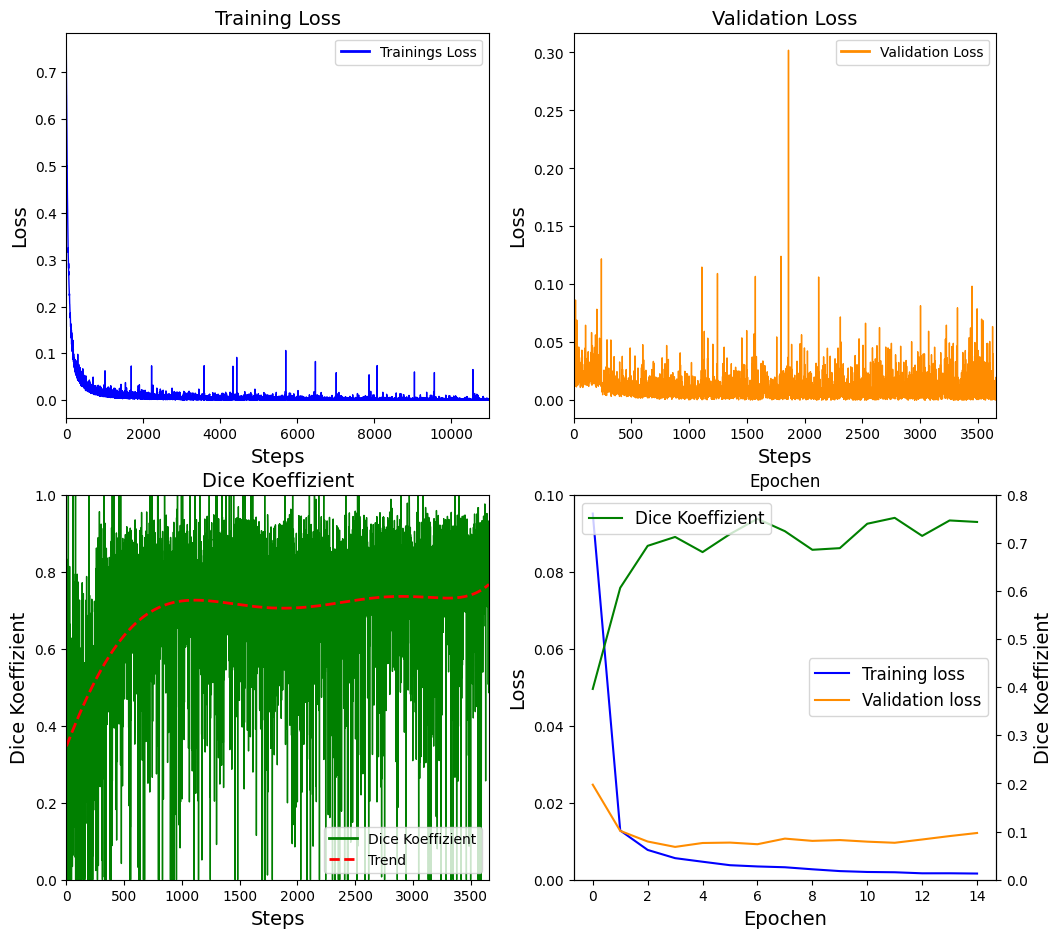

In [89]:
orange = '#FF8C00'
gray = '#808080'
# plt.rcParams.update({'font.weight': 'normal'})
# plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(2,2, figsize=(12, 11))
train_plot = plot_figure(train_loss_steps, 'Trainings Loss', 'Steps', 'Loss', ax=axs[0, 0], color='b')
axs[0, 0].set_title('Training Loss', fontsize=14)
loss_plot = plot_figure(val_loss_steps, 'Validation Loss', 'Steps', 'Loss', ax=axs[0, 1], color=orange)
axs[0, 1].set_title('Validation Loss', fontsize=14)
jaccard_plot = plot_figure(validation_dice_steps, 'Dice Koeffizient', 'Steps', 'Dice Koeffizient', ax=axs[1, 0], color='g', trend=True)
axs[1, 0].set_title('Dice Koeffizient', fontsize=14)
axs[1, 0].set_ylim(0, 1)

ax4a = axs[1, 1]
ax4b = ax4a.twinx()
axs[1, 1].set_title('Epochen')
ax4a.plot(train_loss_epochs, 'b-', label='Training loss')
ax4a.plot(val_loss_epochs, '-', color=orange, label='Validation loss')

# ax4 = ax3.twinx()
ax4b.plot(val_dice_epochs, 'g-', label='Dice Koeffizient')
ax4a.set_xlabel('Epochen', fontsize=14)
ax4a.set_ylabel('Loss', fontsize=14)
ax4b.set_ylabel('Dice Koeffizient', fontsize=14)
ax4a.legend(loc='center right', fontsize=12)
ax4b.legend(loc='upper left', fontsize=12)
ax4a.set_ylim(0, 0.1)
ax4b.set_ylim(0, 0.8);

In [90]:
fig.savefig('figures/cleaned_verified_data/trainings_validated_grid.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/trainings_validated_grid.svg', bbox_inches='tight')

## Evaluate Model

In [92]:
class GeoImageDataset(Dataset):
    def __init__(self, img_dir: Path, mask_dir:Path, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = os.listdir(self.img_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform = transform
        

    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        # Load image
        img_path = self.img_dir / self.img_files[idx]
        # mask and img_file have so far the same name
        mask_path = self.mask_dir / self.img_files[idx]
        img = torch.load(img_path)
        # converts bool mask into integer (0/1)
        mask = torch.load(mask_path).long()
        # Apply transform (if any)
        if self.transform:
            img = self.transform(img)
        
        return img, mask, img_path, mask_path

In [94]:
val_images_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned_verified\val\images")
val_masks_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned_verified\val\masks")

val_dataset = GeoImageDataset(val_images_path, val_masks_path)

In [96]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [104]:
model = smp.Unet(
    encoder_name=timm_resnest14d,
    encoder_weights='imagenet',
    in_channels=4,
    classes=1,
    activation='sigmoid',
).to(device)
model_path = "models/u_net_undersampling_cleaned_verified_timm-resnest14d_15_16_0.005_None.pt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [105]:
model.eval() # enabling the eval mode to test with new samples.
metric = Dice(mode="binary", zero_division=1).to(device)

In [106]:
index_list = []
metric_list = []
mask_size_list = []
brightness_image_list = []
img_path_list = []
mask_path_list = []
pred_list = []

for i, sample in enumerate(val_dataset):
    img, mask, img_path, mask_path = val_dataset[i]

    img = img.to(device)
    mask = mask.to(device)

    if mask.sum() <= 1:
        continue
    with torch.no_grad():
        pred = model(img.unsqueeze(0))

    IoU = metric(pred[:,0], mask).detach().cpu().numpy()
    index_list.append(i)
    metric_list.append(IoU)
    mask_size_list.append(mask.sum().cpu().numpy())
    brightness_image_list.append(img.mean().cpu().numpy())
    img_path_list.append(img_path)
    mask_path_list.append(mask_path)
    pred_list.append(pred[:,0].detach().cpu().numpy())

df = pd.DataFrame({'index': index_list, 'metric': metric_list, 'mask_size': mask_size_list, 'brightness': brightness_image_list,'pred_mask': pred_list, 'img_path': img_path_list, 'mask_path': mask_path_list})

df = df.sort_values('metric', ascending=False)

df = df.reset_index(drop=True)

df.head()

,index,metric,mask_size,brightness,pred_mask,img_path,mask_path
0,3183,0.98819005,1829,0.29417557,"[[[0.0014037197, 0.00012820572, 7.006326e-05, ...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
1,3182,0.98756564,1829,0.3034925,"[[[0.001518699, 0.00013153754, 5.1992265e-05, ...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
2,3135,0.9811569,2292,0.22346967,"[[[0.0018316967, 0.00014366575, 6.3014544e-05,...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
3,3197,0.9799735,7622,0.24084537,"[[[0.0042232997, 0.000403566, 0.0001533128, 0....",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
4,3163,0.979876,4620,0.26001477,"[[[0.52524, 0.69300437, 0.8199751, 0.83635527,...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...


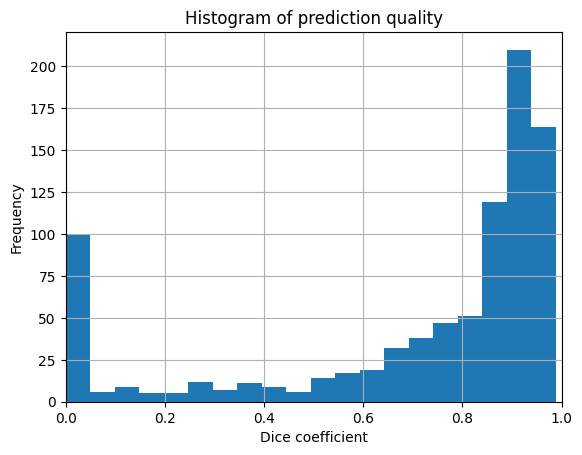

In [265]:
fig, ax = plt.subplots()
ax.hist(df['metric'], bins=20, )
# add grid
ax.grid(True)
ax.set_xlabel('Dice coefficient')
ax.set_ylabel('Frequency')
ax.set_xlim(0, 1)
ax.set_title('Histogram of prediction quality');

In [266]:
fig.savefig('figures/cleaned_verified_data/histogram_dice_eng.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/histogram_dice_eng.svg', bbox_inches='tight')

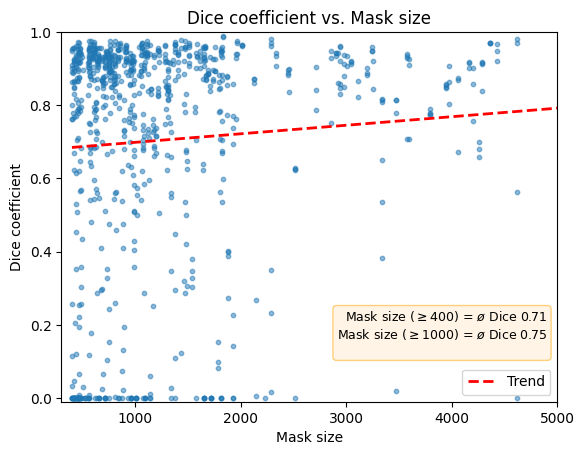

In [272]:
mask_size_sorted = np.array(mask_size_list)
metric_sorted = np.array(metric_list)
sort_indices = np.argsort(mask_size_sorted)
mask_size_sorted = mask_size_sorted[sort_indices]
metric_sorted = metric_sorted[sort_indices]

# Filtern Sie die Daten und berechnen Sie den Durchschnitt
mask_size_filtered = mask_size_sorted[mask_size_sorted >= 1000]
metric_filtered = metric_sorted[mask_size_sorted >= 1000]
mean_metric_filtered = np.mean(metric_filtered)
mean_metric = np.mean(metric_sorted)
z = np.polyfit(mask_size_sorted, metric_sorted, 1)
p = np.poly1d(z)

fig, ax = plt.subplots()
ax.plot(mask_size_sorted, p(mask_size_sorted), 'r--', label='Trend', linewidth=2)
ax.scatter(mask_size_sorted, metric_sorted, s=10, alpha=0.5)
# ax.plot([1000, 50000], [mean_metric_filtered, mean_metric_filtered], 'r--')
# ax.plot([0, 50000],[mean_y, mean_y], 'b--')
stats = (f'Mask size ($\\geq 400$) = $\\o$ Dice {mean_metric:.2f}\n'
            f'Mask size ($\\geq 1000$) = $\\o$ Dice {mean_metric_filtered:.2f}\n')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax.text(0.98, 0.13, stats,  fontsize=9, bbox=bbox, transform=plt.gca().transAxes, horizontalalignment='right')
ax.set_title('Dice coefficient vs. Mask size')
ax.set_xlabel('Mask size')
ax.set_ylabel('Dice coefficient')
ax.legend()
ax.set_xlim(300, 5000)
ax.set_ylim(-0.01, 1.);

In [273]:
fig.savefig('figures/cleaned_verified_data/mask_size_dice_eng.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/mask_size_dice_eng.svg', bbox_inches='tight')

## Show Images with different predictions

In [212]:
def show_rgb_sample(sample, ax=ax1, show_image=True, show_mask=True, show_pred=True, show_title=True, title='Image', show_axis=False,):
    if show_image:
        img = torch.load(sample.img_path)
        ax.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)))
    
    if show_mask:
        mask = torch.load(sample.mask_path)[0,:,:,]
        ax.imshow(torch.Tensor.numpy(mask), cmap='jet') #, alpha=0.5*(mask==True)

    if show_pred:
        pred = sample.pred_mask[0,:,:]
        ax.imshow(pred, cmap='jet') # , alpha=0.5*(pred>0.5)

    if show_title:
        ax.set_title(title, fontsize=18)

    if not show_axis:
        ax.axis('off')

In [173]:
len(df)

881

In [211]:
sample_good_pred = df.iloc[2]
sample_medium_pred = df.iloc[700]
sample_bad_pred = df.iloc[-1]
sample_miss_labeled = df.iloc[706] # 706

0.53704625


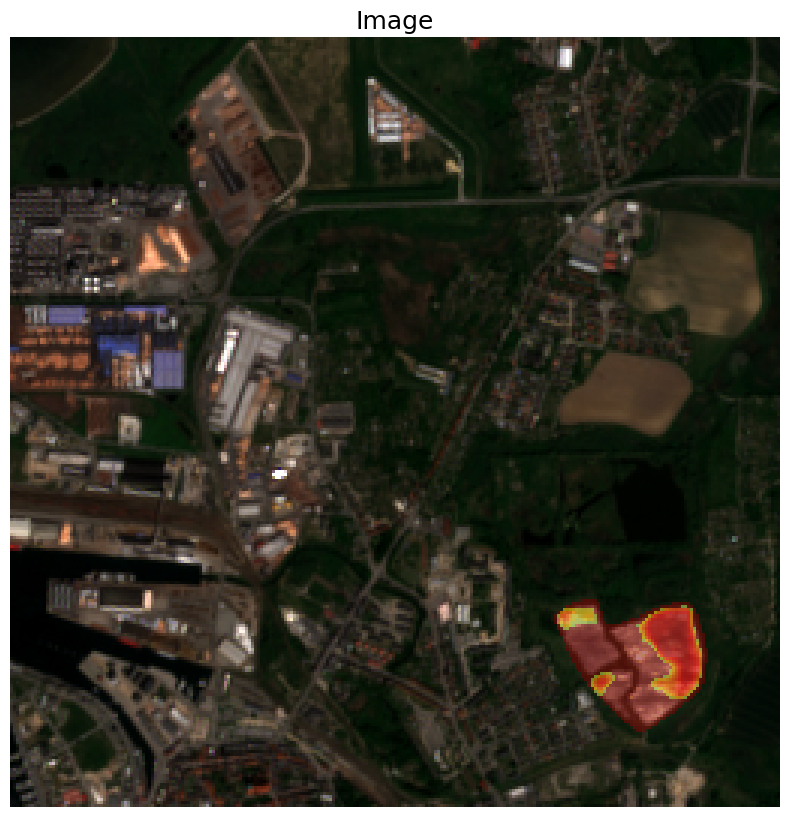

In [210]:
# To show those images, use the commented code in the show_rgb_sample function
sample = df.iloc[700]
fig, ax1 = plt.subplots(figsize=(10, 10))
print(sample.metric)
show_rgb_sample(sample, ax=ax1, show_image=True, show_mask=True, show_pred=True, show_title=True, title='Image', show_axis=False,)

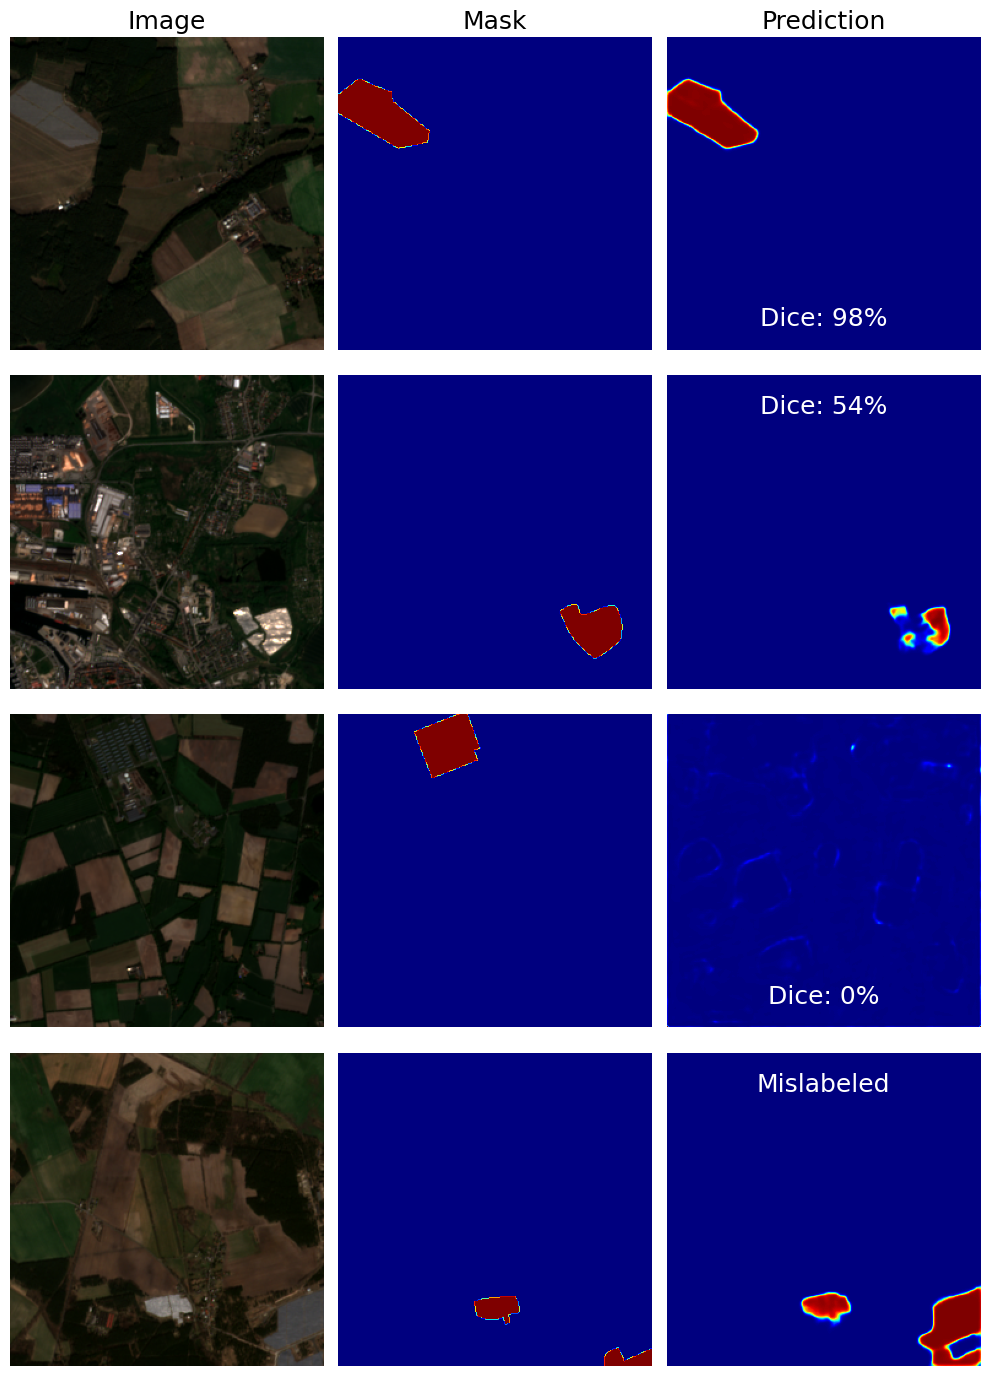

In [218]:
fig, axes = plt.subplots(4, 3, figsize=(10,14))
ax11, ax12, ax13 = axes[0]
ax21, ax22, ax23 = axes[1]
ax31, ax32, ax33 = axes[2]
ax41, ax42, ax43 = axes[3]

show_rgb_sample(sample_good_pred, ax11, show_mask=False, show_pred=False, show_title=True, title='Image')
show_rgb_sample(sample_good_pred, ax12, show_image=False, show_pred=False, show_title=True, title='Mask')
show_rgb_sample(sample_good_pred, ax13, show_image=False, show_mask=False, show_title=True, title='Prediction')
ax13.text(0.5, 0.1, f'Dice: {sample_good_pred.metric:.0%}', horizontalalignment='center', verticalalignment='center', transform=ax13.transAxes, fontsize=18, color='white')

show_rgb_sample(sample_medium_pred, ax21, show_mask=False, show_pred=False, show_title=False, title='Image')
show_rgb_sample(sample_medium_pred, ax22, show_image=False, show_pred=False, show_title=False, title='Mask')
show_rgb_sample(sample_medium_pred, ax23, show_image=False, show_mask=False, show_title=False, title='Prediction')
ax23.text(0.5, 0.9, f'Dice: {sample_medium_pred.metric:.0%}', horizontalalignment='center', verticalalignment='center', transform=ax23.transAxes, fontsize=18, color='white')

show_rgb_sample(sample_bad_pred, ax31, show_mask=False, show_pred=False, show_title=False, title='Image')
show_rgb_sample(sample_bad_pred, ax32, show_image=False, show_pred=False, show_title=False, title='Mask')
show_rgb_sample(sample_bad_pred, ax33, show_image=False, show_mask=False, show_title=False, title='Prediction')
ax33.text(0.5, 0.1, f'Dice: {sample_bad_pred.metric:.0%}', horizontalalignment='center', verticalalignment='center', transform=ax33.transAxes, fontsize=18, color='white')

show_rgb_sample(sample_miss_labeled, ax41, show_mask=False, show_pred=False, show_title=False, title='Image')
show_rgb_sample(sample_miss_labeled, ax42, show_image=False, show_pred=False, show_title=False, title='Mask')
show_rgb_sample(sample_miss_labeled, ax43, show_image=False, show_mask=False, show_title=False, title='Prediction')
ax43.text(0.5, 0.9, f'Mislabeled', horizontalalignment='center', verticalalignment='center', transform=ax43.transAxes, fontsize=18, color='white')

fig.tight_layout()

In [219]:
fig.savefig('figures/cleaned_verified_data/prediction_samples_validated_eng.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/prediction_samples_validated_eng.svg', bbox_inches='tight')

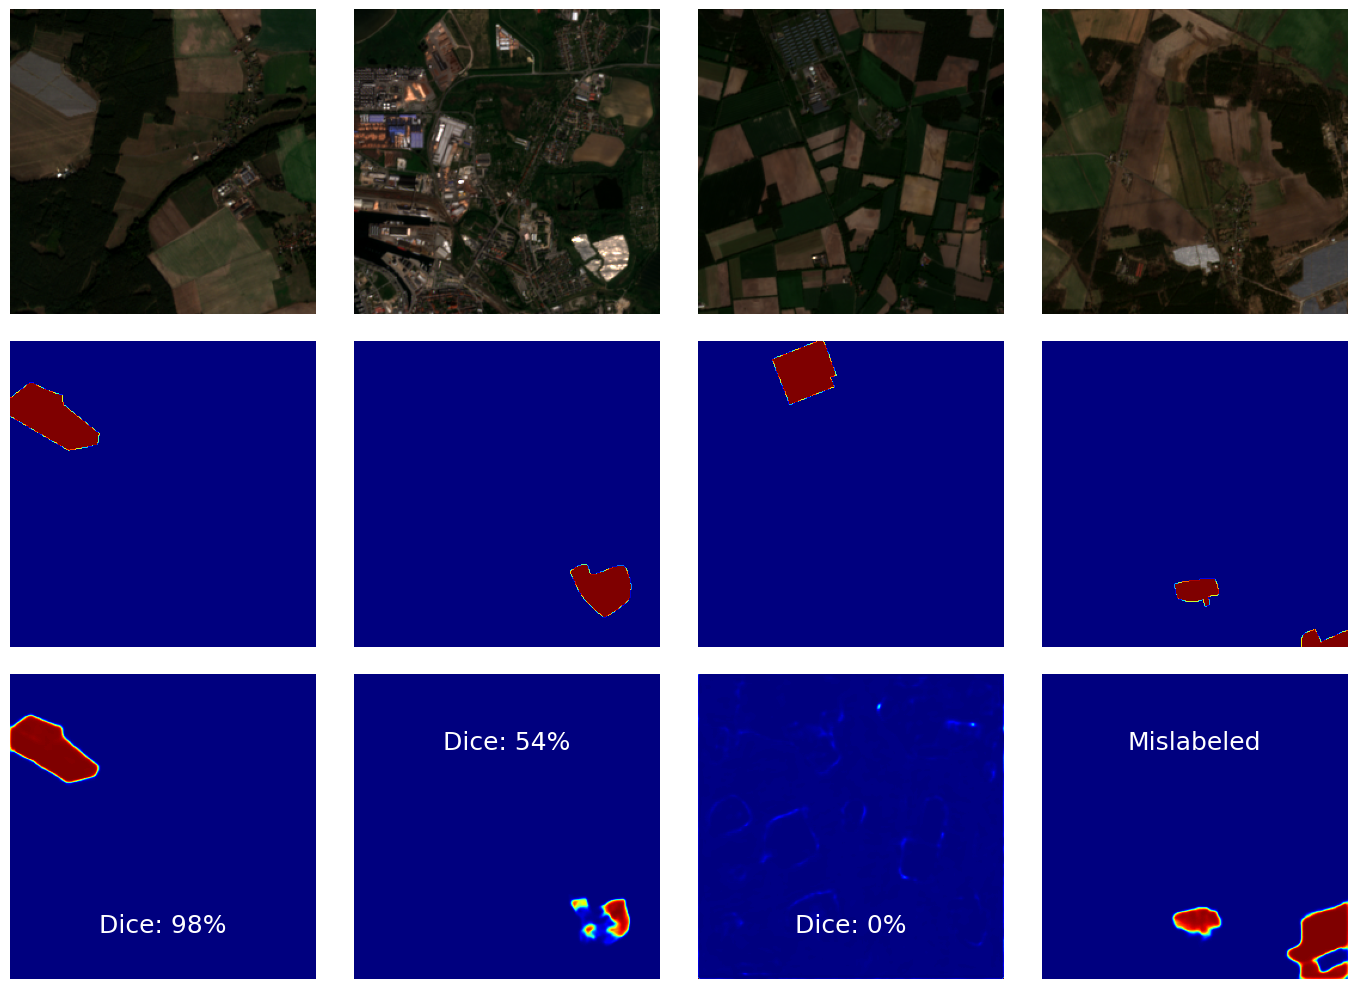

In [259]:
fig, axes = plt.subplots(3, 4, figsize=(14,10))
ax11, ax12, ax13, ax14 = axes[0]
ax21, ax22, ax23, ax24 = axes[1]
ax31, ax32, ax33, ax34 = axes[2]

show_rgb_sample(sample_good_pred, ax11, show_mask=False, show_pred=False, show_title=False, title='Image')
show_rgb_sample(sample_medium_pred, ax12, show_mask=False, show_pred=False, show_title=False, title='Image')
show_rgb_sample(sample_bad_pred, ax13, show_mask=False, show_pred=False, show_title=False, title='Image')
show_rgb_sample(sample_miss_labeled, ax14, show_mask=False, show_pred=False, show_title=False, title='Image')

show_rgb_sample(sample_good_pred, ax21, show_image=False, show_pred=False, show_title=False, title='Mask')
show_rgb_sample(sample_medium_pred, ax22, show_image=False, show_pred=False, show_title=False, title='Mask')
show_rgb_sample(sample_bad_pred, ax23, show_image=False, show_pred=False, show_title=False, title='Mask')
show_rgb_sample(sample_miss_labeled, ax24, show_image=False, show_pred=False, show_title=False, title='Mask')

show_rgb_sample(sample_good_pred, ax31, show_image=False, show_mask=False, show_title=False, title='Prediction')
show_rgb_sample(sample_medium_pred, ax32, show_image=False, show_mask=False, show_title=False, title='Prediction')
show_rgb_sample(sample_bad_pred, ax33, show_image=False, show_mask=False, show_title=False, title='Prediction')
show_rgb_sample(sample_miss_labeled, ax34, show_image=False, show_mask=False, show_title=False, title='Prediction')

ax31.text(0.5, -2.0, f'Dice: {sample_good_pred.metric:.0%}', horizontalalignment='center', verticalalignment='center', transform=ax11.transAxes, fontsize=18, color='white')
ax32.text(0.5, -1.4, f'Dice: {sample_medium_pred.metric:.0%}', horizontalalignment='center', verticalalignment='center', transform=ax12.transAxes, fontsize=18, color='white')
ax33.text(0.5, -2.0, f'Dice: {sample_bad_pred.metric:.0%}', horizontalalignment='center', verticalalignment='center', transform=ax13.transAxes, fontsize=18, color='white')
ax34.text(0.5, -1.4, f'Mislabeled', horizontalalignment='center', verticalalignment='center', transform=ax14.transAxes, fontsize=18, color='white')

fig.tight_layout()

In [260]:
fig.savefig('figures/cleaned_verified_data/prediction_samples_validated_horizontal_eng.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/prediction_samples_validated_horizontal_eng.svg', bbox_inches='tight')